#

# Sistem Inferensi Fuzzy dalam Klasifikasi Kualitas Air Minum
Anggota:
- Ariq Naufal Fadhlurrahman - 103012480010
- M. Agung Isra Narwin - 103012480038

In [69]:
# Import dependencies
import numpy as np 
import skfuzzy as fuzz 
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing

In [72]:
# Load dataset
df = pd.read_csv('water_potability.csv')

# Menghapus kolom yang kosong
df_filtered = df[["ph", "Turbidity", "Solids", "Potability"]].dropna()

# Ambil fitur yang digunakan untuk fuzzy system
features = ['ph', 'Turbidity', "Solids"]
target = 'Potability'

# Normalisasi data
scaler = MinMaxScaler()
df_filtered[["ph", "Turbidity", "Solids"]] = scaler.fit_transform(df_filtered[["ph", "Turbidity", "Solids"]])

x = df_filtered[features]
y = df_filtered[target]

print("Jumlah data:", len(x))


Jumlah data: 2785


## Rentang nilai

In [4]:
ph_area = np.arange(0, 1.01, 0.01) # pH Air
turbidity_area = np.arange(0, 1.01, 0.01) # Tingkat kekeruhan
solids_area = np.arange(0, 1.01, 0.01) # Total padatan terlarut
potability_area = np.arange(0, 1.01, 0.01) # Potabilitas air

## Metode Mamdani

In [ ]:
# Fuzzy input
ph = ctrl.Antecedent(ph_area, 'pH')
turbidity = ctrl.Antecedent(turbidity_area, 'turbidity')
solids = ctrl.Antecedent(solids_area, 'solids')

# Fuzzy output
potability = ctrl.Consequent(potability_area, 'potability')

# Membership functions untuk pH
ph['low'] = fuzz.trapmf(ph.universe, [0, 0, 0.46, 0.502])
ph['normal'] = fuzz.trimf(ph.universe, [0.46, 0.502, 0.552])
ph['high'] = fuzz.trapmf(ph.universe, [0.502, 0.552, 1, 1])

# Membership functions untuk Tingkat kekeruhan
turbidity['clear'] = fuzz.trapmf(turbidity.universe, [0, 0, 0.435, 0.497])
turbidity['medium'] = fuzz.trimf(turbidity.universe, [0.435, 0.497, 0.569])
turbidity['murky'] = fuzz.trapmf(turbidity.universe, [0.497, 0.569, 1, 1])

# Membership functions untuk Total padatan terlarut
solids['low'] = fuzz.trapmf(solids.universe, [0, 0, 0.302, 0.363])
solids['medium'] = fuzz.trimf(solids.universe, [0.302, 0.363, 0.435])
solids['high'] = fuzz.trapmf(solids.universe, [0.363, 0.435, 1, 1])

# Membership functions untuk Potabilitas air
potability['not_potable'] = fuzz.trimf(potability.universe, [0, 0, 0.55])
potability['potable'] = fuzz.trimf(potability.universe, [0.45, 1, 1])

# Rules
rules = [
    ctrl.Rule(ph['low'] & turbidity['clear'] & solids['low'], potability['potable']),
    ctrl.Rule(ph['low'] & turbidity['clear'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['clear'] & solids['high'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['medium'] & solids['low'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['medium'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['medium'] & solids['high'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['murky'] & solids['low'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['murky'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['low'] & turbidity['murky'] & solids['high'], potability['not_potable']),

    ctrl.Rule(ph['normal'] & turbidity['clear'] & solids['low'], potability['potable']),
    ctrl.Rule(ph['normal'] & turbidity['clear'] & solids['medium'], potability['potable']),
    ctrl.Rule(ph['normal'] & turbidity['clear'] & solids['high'], potability['not_potable']),
    ctrl.Rule(ph['normal'] & turbidity['medium'] & solids['low'], potability['potable']),
    ctrl.Rule(ph['normal'] & turbidity['medium'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['normal'] & turbidity['medium'] & solids['high'], potability['not_potable']),
    ctrl.Rule(ph['normal'] & turbidity['murky'] & solids['low'], potability['not_potable']),
    ctrl.Rule(ph['normal'] & turbidity['murky'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['normal'] & turbidity['murky'] & solids['high'], potability['not_potable']),

    ctrl.Rule(ph['high'] & turbidity['clear'] & solids['low'], potability['potable']),
    ctrl.Rule(ph['high'] & turbidity['clear'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['clear'] & solids['high'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['medium'] & solids['low'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['medium'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['medium'] & solids['high'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['murky'] & solids['low'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['murky'] & solids['medium'], potability['not_potable']),
    ctrl.Rule(ph['high'] & turbidity['murky'] & solids['high'], potability['not_potable']),
]

potability_ctrl = ctrl.ControlSystem(rules)

def mamdani_inference(ph, turbidity, solids):
    potability_sim = ctrl.ControlSystemSimulation(potability_ctrl)
    potability_sim.input['pH'] = ph
    potability_sim.input['turbidity'] = turbidity
    potability_sim.input['solids'] = solids

    potability_sim.compute()
    return potability_sim.output['potability']

## Graf Membership Function

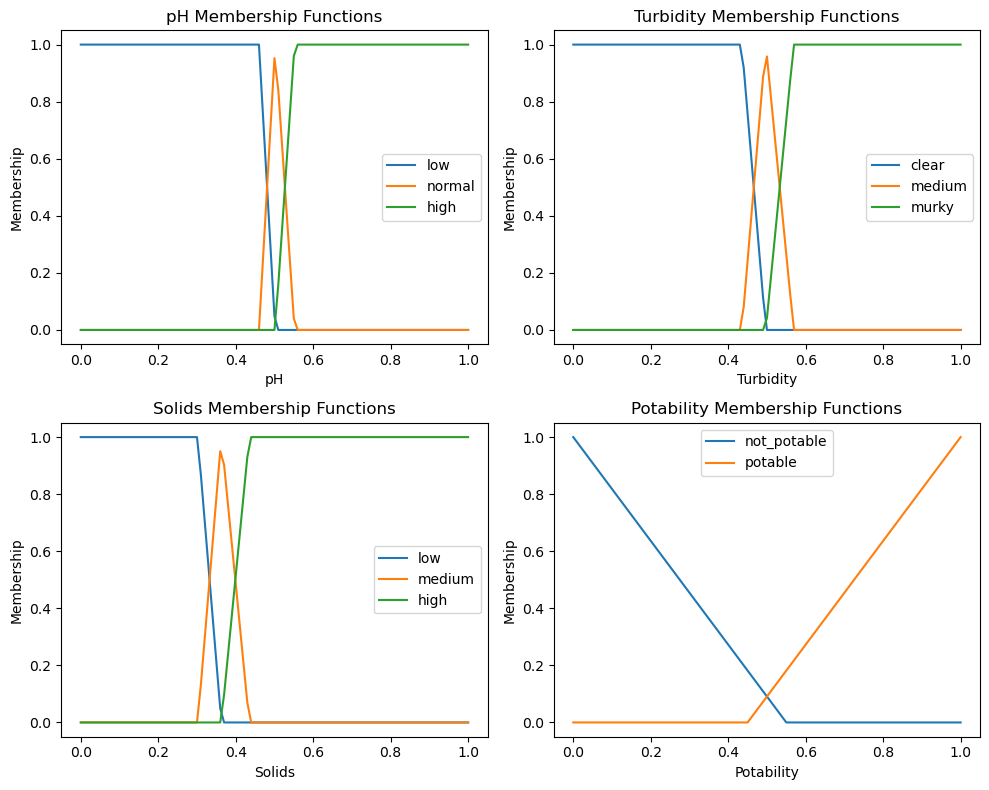

In [54]:
# Plotting the membership functions to grid
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# pH
for term in ph.terms:
	ax[0, 0].plot(ph.universe, ph[term].mf, label=term)
ax[0, 0].set_title('pH Membership Functions')
ax[0, 0].set_xlabel('pH')
ax[0, 0].set_ylabel('Membership')
ax[0, 0].legend()

# Turbidity
for term in turbidity.terms:
	ax[0, 1].plot(turbidity.universe, turbidity[term].mf, label=term)
ax[0, 1].set_title('Turbidity Membership Functions')
ax[0, 1].set_xlabel('Turbidity')
ax[0, 1].set_ylabel('Membership')
ax[0, 1].legend()

# Solids
for term in solids.terms:
	ax[1, 0].plot(solids.universe, solids[term].mf, label=term)
ax[1, 0].set_title('Solids Membership Functions')
ax[1, 0].set_xlabel('Solids')
ax[1, 0].set_ylabel('Membership')
ax[1, 0].legend()

# Potability
for term in potability.terms:
	ax[1, 1].plot(potability.universe, potability[term].mf, label=term)
ax[1, 1].set_title('Potability Membership Functions')
ax[1, 1].set_xlabel('Potability')
ax[1, 1].set_ylabel('Membership')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

## Metode Sugeno

In [ ]:
def sugeno(ph_val, turb_val, solids_val):
    ph_low = fuzz.interp_membership(ph_area, fuzz.trapmf(ph_area, [0, 0, 0.46, 0.502]), ph_val)
    ph_norm = fuzz.interp_membership(ph_area, fuzz.trimf(ph_area, [0.46, 0.502, 0.552]), ph_val)
    ph_high = fuzz.interp_membership(ph_area, fuzz.trapmf(ph_area, [0.502, 0.552, 1, 1]), ph_val)

    turb_low = fuzz.interp_membership(turbidity_area, fuzz.trapmf(turbidity_area, [0, 0, 0.435, 0.497]), turb_val)
    turb_med = fuzz.interp_membership(turbidity_area, fuzz.trimf(turbidity_area, [0.435, 0.497, 0.569]), turb_val)
    turb_high = fuzz.interp_membership(turbidity_area, fuzz.trapmf(turbidity_area, [0.497, 0.569, 1, 1]), turb_val)

    solids_low = fuzz.interp_membership(solids_area, fuzz.trapmf(solids_area, [0, 0, 0.302, 0.363]), solids_val)
    solids_med = fuzz.interp_membership(solids_area, fuzz.trimf(solids_area, [0.302, 0.363, 0.435]), solids_val)
    solids_high = fuzz.interp_membership(solids_area, fuzz.trapmf(solids_area, [0.363, 0.435, 1, 1]), solids_val)

    rules = [
        # ph low
        (min(ph_low, turb_low, solids_low), 1),
        (min(ph_low, turb_low, solids_med), 0),
        (min(ph_low, turb_low, solids_high), 0),
        (min(ph_low, turb_med, solids_low), 0),
        (min(ph_low, turb_med, solids_med), 0),
        (min(ph_low, turb_med, solids_high), 0),
        (min(ph_low, turb_high, solids_low), 0),
        (min(ph_low, turb_high, solids_med), 0),
        (min(ph_low, turb_high, solids_high), 0),

        # ph normal
        (min(ph_norm, turb_low, solids_low), 1),
        (min(ph_norm, turb_low, solids_med), 1),
        (min(ph_norm, turb_low, solids_high), 0),
        (min(ph_norm, turb_med, solids_low), 1),
        (min(ph_norm, turb_med, solids_med), 0),
        (min(ph_norm, turb_med, solids_high), 0),
        (min(ph_norm, turb_high, solids_low), 0),
        (min(ph_norm, turb_high, solids_med), 0),
        (min(ph_norm, turb_high, solids_high), 0),

        # ph high
        (min(ph_high, turb_low, solids_low), 1),
        (min(ph_high, turb_low, solids_med), 0),
        (min(ph_high, turb_low, solids_high), 0),
        (min(ph_high, turb_med, solids_low), 0),
        (min(ph_high, turb_med, solids_med), 0),
        (min(ph_high, turb_med, solids_high), 0),
        (min(ph_high, turb_high, solids_low), 0),
        (min(ph_high, turb_high, solids_med), 0),
        (min(ph_high, turb_high, solids_high), 0),
    ]

    # Weighted average (Sugeno)
    numerator = sum([strength * output for strength, output in rules])
    denominator = sum([strength for strength, _ in rules])

    return 0 if denominator == 0 else numerator / denominator

## Perbandingan kedua metode

In [71]:
y_pred_mamdani = []
y_pred_sugeno = []

for _, row in x.iterrows():
    ph_val, turb_val, solids_val = row[features]

    potability_mamdani = mamdani_inference(ph_val, turb_val, solids_val)
    potability_sugeno = sugeno(ph_val, turb_val, solids_val)

    y_pred_mamdani.append(1 if potability_mamdani >= 0.5 else 0)
    y_pred_sugeno.append(1 if potability_sugeno >= 0.5 else 0)

accuracy_mamdani = accuracy_score(y, y_pred_mamdani)
accuracy_sugeno = accuracy_score(y, y_pred_sugeno)
f1_mamdani = f1_score(y, y_pred_mamdani,)
f1_sugeno = f1_score(y, y_pred_sugeno,)
recall_mamdani = recall_score(y, y_pred_mamdani,)
recall_sugeno = recall_score(y, y_pred_sugeno,)
precision_mamdani = precision_score(y, y_pred_mamdani,)
precision_sugeno = precision_score(y, y_pred_sugeno,)

print("Mamdani Inference Results:")
print(f"Accuracy: {accuracy_mamdani * 100:.2f}%")
print(f"F1 Score: {f1_mamdani * 100:.2f}%")
print(f"Recall: {recall_mamdani * 100:.2f}%")
print(f"Precision: {precision_mamdani * 100:.2f}%")

print("\nSugeno Inference Results:")
print(f"Accuracy: {accuracy_sugeno * 100:.2f}%")
print(f"F1 Score: {f1_sugeno * 100:.2f}%")
print(f"Recall: {recall_sugeno * 100:.2f}%")
print(f"Precision: {precision_sugeno * 100:.2f}%")



Mamdani Inference Results:
Accuracy: 59.71%
F1 Score: 9.37%
Recall: 5.27%
Precision: 42.34%

Sugeno Inference Results:
Accuracy: 55.44%
F1 Score: 25.02%
Recall: 18.80%
Precision: 37.36%
